In [1]:
import os
import h5py
import numpy as np
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, Input
from keras.regularizers import l2, l1
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
from keras.utils.data_utils import get_file

Using TensorFlow backend.


In [3]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:") 
    print_best_model_results(hist)

In [4]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [5]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [6]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [7]:
def train_top_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
    
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f) 
        
    return model, fit.history

In [8]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history        

In [9]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='binary', shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

## Defining input data

In [10]:
location = 'data2'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 1824
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 448

img_width, img_height = 256,256
epochs = 50
batch_size = 16

In [ ]:
save_bottleneck_features()

In [11]:
d2_model1, d2_history1 = train_top_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1824 samples, validate on 448 samples
Epoch 1/50
1824/1824 [==============================] - 19s 10ms/step - loss: 7.9614 - acc: 0.5016 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to data2/top_model_weights.h5
Epoch 2/50
1824/1824 [==============================] - 19s 10ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/50
1824/1824 [==============================] - 18s 10ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/50
1824/1824 [==============================] - 18s 10ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8

Best Model:
epoch: 9 , val_acc: 0.9375 , val_loss: 0.2073782096683447


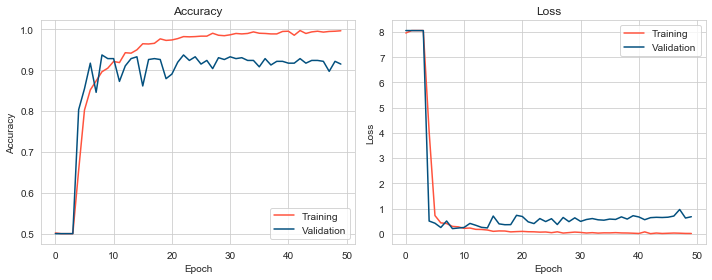

In [12]:
plot_metrics(d2_history1)

### Fine Tuning

In [ ]:
ft_model, ft_history = finetune_binary_model()

Model loaded.
Found 1824 images belonging to 2 classes.
Found 448 images belonging to 2 classes.
Epoch 1/50
114/114 [==============================] - 1571s 14s/step - loss: 0.3264 - acc: 0.8799 - val_loss: 0.2074 - val_acc: 0.9375

Epoch 00001: val_acc improved from -inf to 0.93750, saving model to data2/ft_model.h5
Epoch 2/50
114/114 [==============================] - 1573s 14s/step - loss: 0.3228 - acc: 0.8871 - val_loss: 0.2074 - val_acc: 0.9375

Epoch 00002: val_acc did not improve from 0.93750
Epoch 3/50
114/114 [==============================] - 24835s 218s/step - loss: 0.3095 - acc: 0.8860 - val_loss: 0.2074 - val_acc: 0.9375

Epoch 00003: val_acc did not improve from 0.93750
Epoch 4/50
114/114 [==============================] - 38145s 335s/step - loss: 0.3335 - acc: 0.8854 - val_loss: 0.2074 - val_acc: 0.9375

Epoch 00004: val_acc did not improve from 0.93750
Epoch 5/50
114/114 [==============================] - 1602s 14s/step - loss: 0.3127 - acc: 0.8942 - val_loss: 0.2074 - 

In [ ]:
plot_metrics(ft_history)

### Load Model

In [17]:
ft_model = load_model(location+'/ft_model.h5')

Instructions for updating:
Use tf.cast instead.


C:\Anaconda3\envs\envdlcv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
with open('data1a/top_history.txt') as f:    
    top_history = json.load(f)

In [ ]:
with open('data1a/ft_history.txt') as f:    
    ft_history = json.load(f)

In [ ]:
plot_acc_metrics(top_history, ft_history)

In [22]:
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [51]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 448 images belonging to 2 classes.


KeyboardInterrupt: 

In [ ]:
heatmap_laebls = ['Damaged', 'Whole']

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

In [ ]:
sns.heatmap(cm, annot=Ture, annot_kws={"size":16}, fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

## Pipe2

In [11]:
def pipe2(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists....")
    print(pred)
    if(pred[0][0]<=0.5):
        print("Validation complete - proceed to location and severity determination")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")      

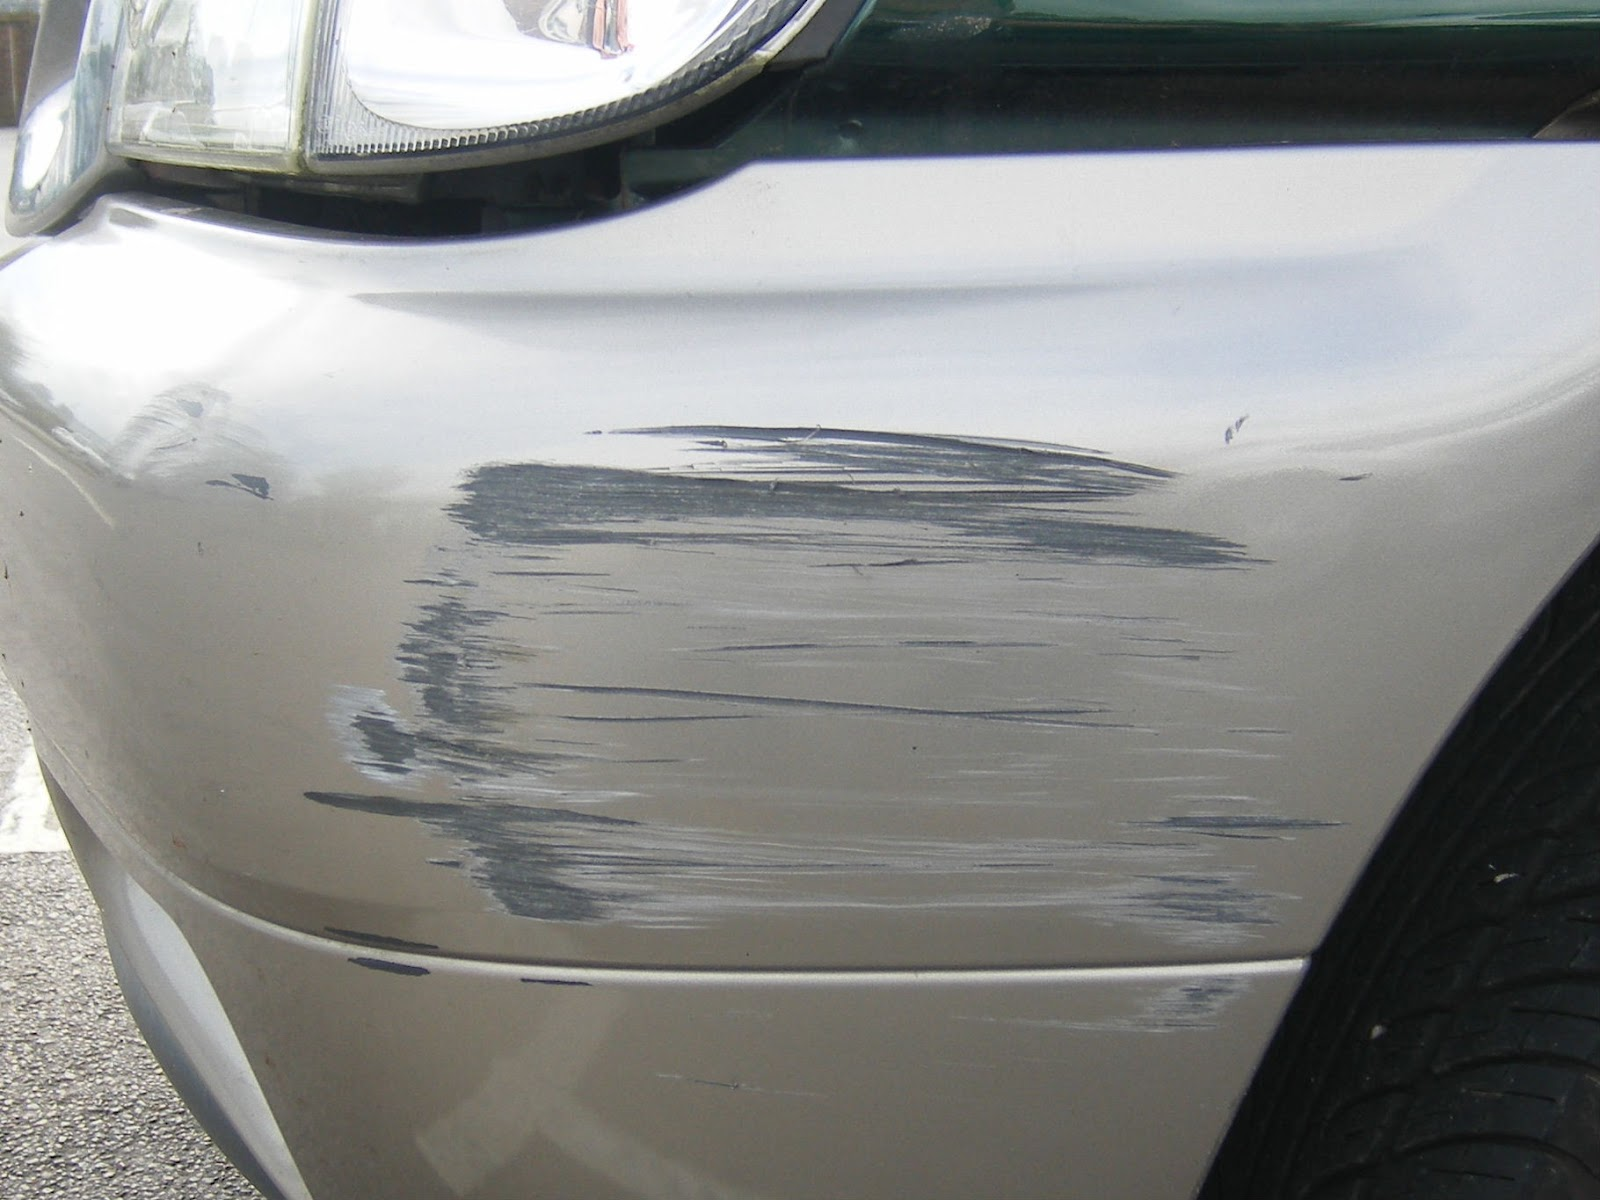

In [12]:
Image('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG')

In [18]:
pipe2('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG', ft_model)

Validating that damage exists....
[[0.0002488]]
Validation complete - proceed to location and severity determination


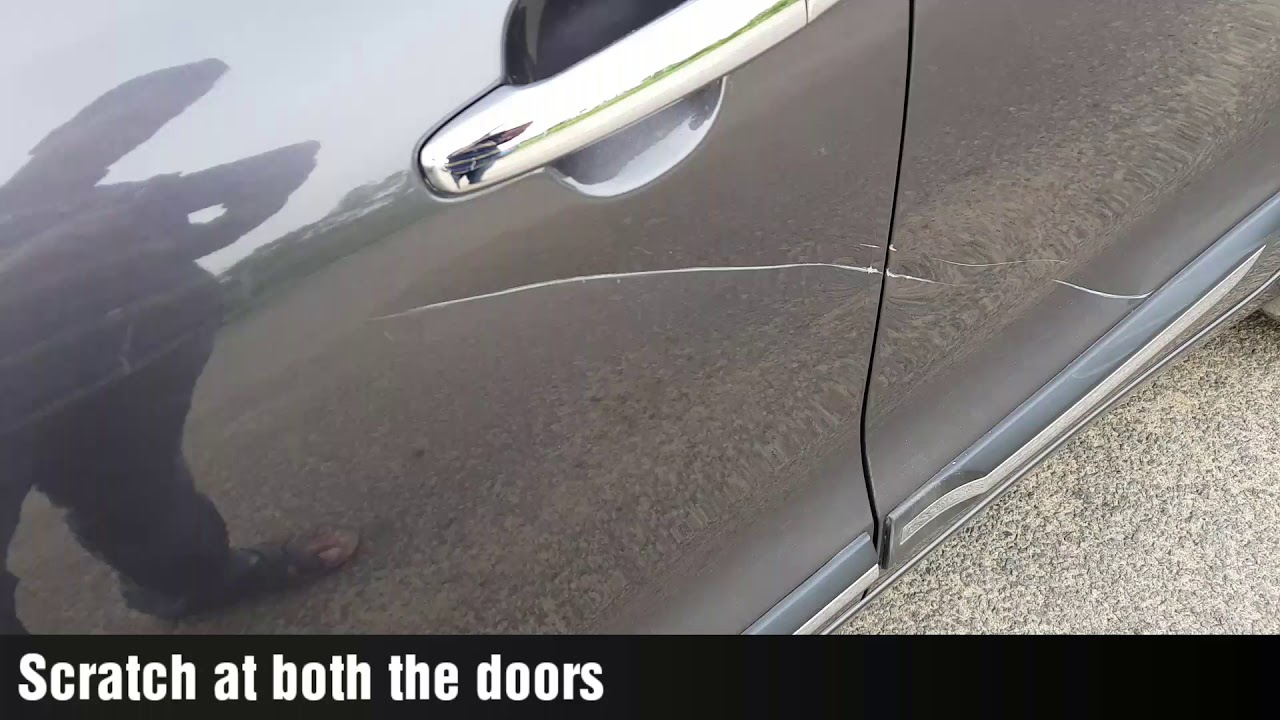

In [40]:
Image('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg')

In [41]:
pipe2('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg', ft_model)

Validating that damage exists....
[[0.01300194]]
Validation complete - proceed to location and severity determination


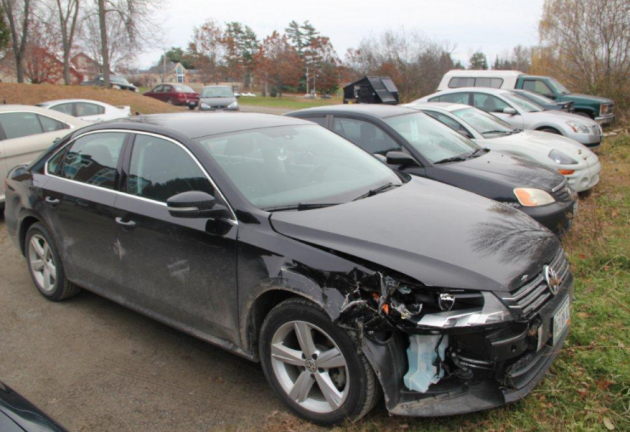

In [47]:
Image('http://blog.automart.co.za/wp-content/uploads/2014/09/Accident_Damaged_Car.png')

In [46]:
pipe2('http://blog.automart.co.za/wp-content/uploads/2014/09/Accident_Damaged_Car.png', ft_model)

Validating that damage exists....
[[0.11757535]]
Validation complete - proceed to location and severity determination
